In [1]:
import numpy as np
import scipy as sp
import pandas as pds
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline

collectblsanal is the cross match between the detection and the injected signals

collectblsanal_kois is the cross match between the detection and the real KOIs (regardless it is false positive, EB or transit planet at this stage)

detect_distance -1 means the period distance is larger than 1%. 

In [2]:
#data = pds.read_csv("collectblsanal.csv", index_col=False)
data = pds.read_csv("collectblsanal_kois.csv", index_col=False, na_values=' nan ')
data = data.dropna()

In [3]:
data.head()

,kepid,segno,period_inj,depth,epoch,MES_expect,MES_scaled,ntransits,BLS_Period,BLS_Tc,...,BLS_deltaChi2,BLS_fraconenight,BLS_Npointsintransit,BLS_Ntransits,BLS_Npointsbeforetransit,BLS_Npointsaftertransit,BLS_Rednoise,BLS_Whitenoise,BLS_SignaltoPinknoise,detect_distance
0,10015937,0,59.658535,1043.8,168.08764,21.2,2.944108,23.466885,12.900600,943.654008,...,-0.0,0.72044,12.0,2.0,14.0,13.0,0.00000,0.00055,5.69304,-1.0
1,10015937,1,59.658535,1043.8,168.08764,21.2,2.944108,23.466885,1.869149,971.604063,...,-0.0,0.15869,49.0,15.0,58.0,56.0,0.00000,0.00054,4.97303,-1.0
2,10015937,2,59.658535,1043.8,168.08764,21.2,2.944108,23.466885,2.497481,1036.035582,...,-0.0,0.19171,39.0,11.0,40.0,41.0,0.00000,0.00049,5.89293,-1.0
3,10015937,3,59.658535,1043.8,168.08764,21.2,2.944108,23.466885,0.710574,1216.330785,...,-0.0,0.17513,17.0,17.0,15.0,16.0,0.00000,0.00050,5.89094,-1.0
4,10015937,4,59.658535,1043.8,168.08764,21.2,2.944108,23.466885,2.866435,1307.433069,...,-0.0,0.22323,15.0,11.0,19.0,18.0,0.00007,0.00051,6.37629,-1.0


We have many signals with high detection significance in BLS but not injection, see figure below (this is because the BLS is detecting the KOI signal in the light curve). This is plotting everything, without considering if the detection period is matched or not. 

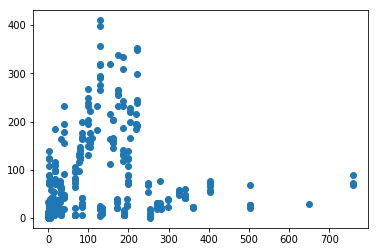

In [4]:
plt.scatter(data.MES_scaled, data.BLS_SignaltoPinknoise)

we use a threshold of 5 times bewtween the two signal to noise estimations to identify some of these signals and examine them (note if you switch to the KOI files, the total number of descripancy detections are smaller). 

In [5]:
select = (data.BLS_SignaltoPinknoise>5*data.MES_scaled) & (data.BLS_SignaltoPinknoise>10)
print len(np.unique(np.array(data[select].kepid)))

21


stars like 1026032, 1722276 are EBs/False positives in original KOIs, stars like 1026861, 1430353, 1436265, 1849555, 1865567, 1867078,  ... are stellar variability signals that our machine learning algorithm should identify as non-transit. The rest are likely false detections on systematic effects, which hopefully our machine learning algorithm will also pick out. 

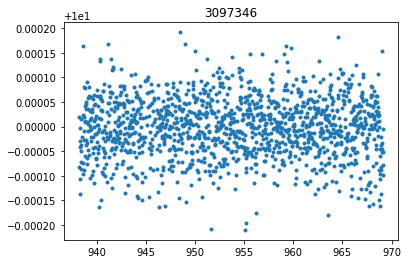

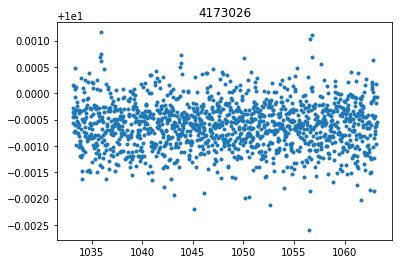

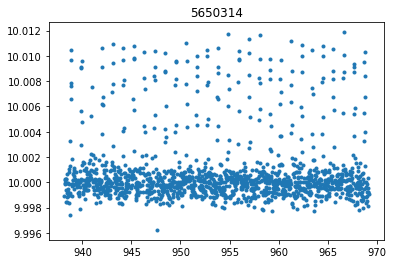

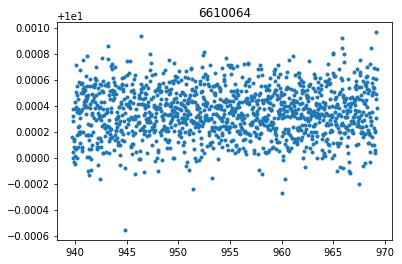

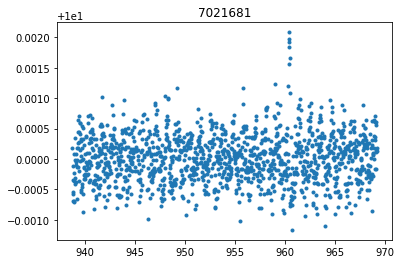

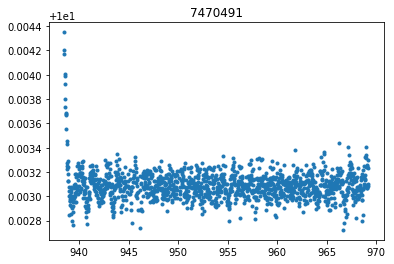

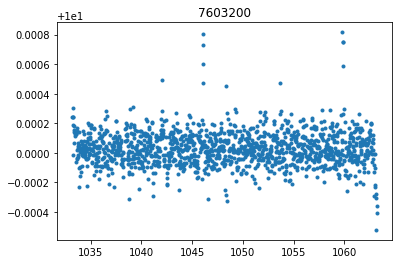

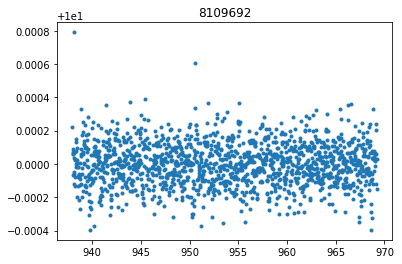

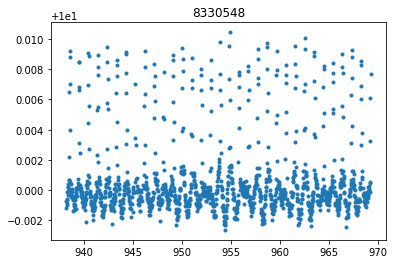

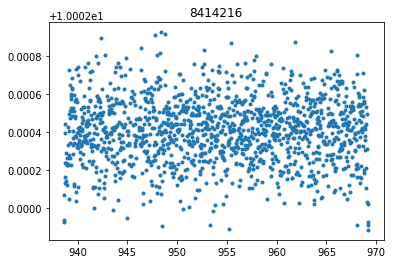

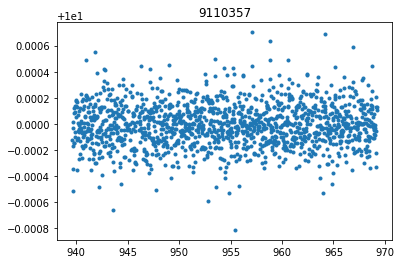

In [6]:
count = 0
for kepid in np.unique(np.array(data[select].kepid)):
    if count<0:
        count+=1
        continue
    infile = "../simulation/primaryinj1/kplr%.9d-0_prim_ltf.lc" % int(kepid)
    lc = np.loadtxt(infile)
    plt.title("%s" % kepid)
    plt.plot(lc[:,0], lc[:,2], '.')
    plt.show()
    count+=1
    if count>10:
        break

A little tool to plot the LCs. 

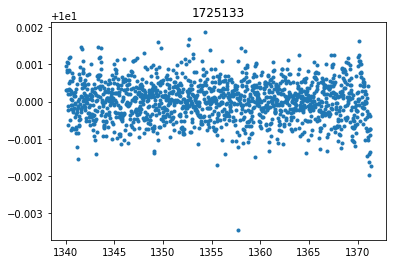

In [7]:
kepid = 1725133
infile = "../simulation/primaryinj1/kplr%.9d-3_prim_ltf.lc" % int(kepid)
lc = np.loadtxt(infile)
plt.title("%s" % kepid)
plt.plot(lc[:,0], lc[:,2], '.')
plt.show()

A zoomed in look at the comparison between scaled MES and BLS SNR. The arm that lie near the x=y line is the actual detections of the injected signals. 

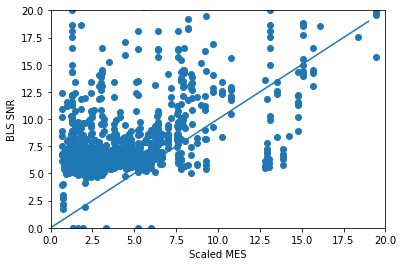

In [8]:
plt.scatter(data.MES_scaled, data.BLS_SignaltoPinknoise)
plt.ylim([0,20])
plt.xlim([0,20])
plt.plot(np.arange(20))
plt.xlabel("Scaled MES")
plt.ylabel("BLS SNR")

Examine the period distance. 

377


(array([ 302.,   47.,   16.,    4.,    3.,    1.,    1.,    0.,    2.,    1.]),
 array([  1.25336146e-06,   9.51704170e-04,   1.90215498e-03,
          2.85260579e-03,   3.80305659e-03,   4.75350740e-03,
          5.70395821e-03,   6.65440902e-03,   7.60485983e-03,
          8.55531063e-03,   9.50576144e-03]),
 <a list of 10 Patch objects>)

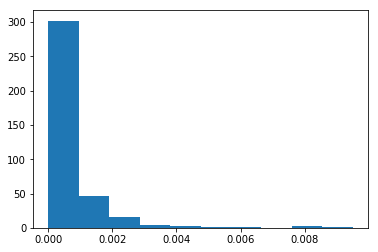

In [9]:
detected = data.detect_distance>0
print len(data.detect_distance[detected])
plt.hist(data.detect_distance[detected])

Let's first loosely say everything with period error smaller than 1% is a detection, and reexamine the scaled MES versus BLS plot again, now the vertical feature is removed for the overall catalog. 

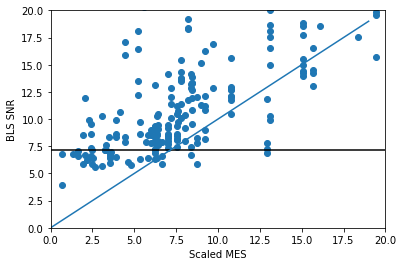

In [10]:
plt.scatter(data.MES_scaled[detected], data.BLS_SignaltoPinknoise[detected])
plt.ylim([0,20])
plt.xlim([0,20])
plt.plot(np.arange(20))
plt.hlines(7.2, 0, 20)
plt.xlabel("Scaled MES")
plt.ylabel("BLS SNR")

Things to DO:

(1) Merged the two tables, if one peak is detected because of a KOI signal, replace the corresponding line in collectblsanal.csv with the KOI line, notedown this is from KOI in a different column. 

(2) create other feature columns for all the peaks. 

(3) Generate True/False sample columns 

(3a) True sample: signals detected because of injected signals (play with the ScaledSNR cut, period distance)
     False sample: signals detected because of neither injected/KOI signals
     signals detected because of KOI signals are removed from this set
     
(3b) True sample: signals detected because of injected/KOI signals (play with the ScaledSNR cut, period distance) 


(4) use previously trained model to test on both (3a) and (3b), not sure if we have enough number of True samples to train on 3a or 3b.  

